# preparing

In [100]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly
import functions
from preprocess_dataframe import get_preprocess_dataframe
import os
import re
import glob
import math
import plotly.graph_objs as go
from shutil import copyfile
import time

## prepare paths

In [101]:
cycle_test=12

In [102]:
times=11

In [103]:
main_path='/media/alena/ext_space/job_analyze'
disabled_path="{}/disabled_folder{}".format(main_path,cycle_test)
frozen_path='{}/frozen_folder{}'.format(main_path,cycle_test)
learn_path='{}/learn_folder{}'.format(main_path,cycle_test)

## prepare func import dataframes

In [104]:
def readcsv(args):
    return pd.read_csv(args, header=None)

def get_df(path_folder,mode,times):
    
    df_ex_pl_time = pd.DataFrame()
    df_ex_pl_time_orig = pd.DataFrame()
    df_explains_plans = pd.DataFrame()
    df_query_err=pd.DataFrame()
    df_query_stat=pd.DataFrame()
    df_query_data=pd.DataFrame()
    filename_basics=glob.glob("{}/*_report.csv".format(path_folder, mode))
    if mode !='disabled':
        filename_others=['{}/{}_aqo_data.csv'.format(path_folder,mode), '{}/{}_aqo_query_stat.csv'.format(path_folder,mode)] 
        dfs = [df_query_data,df_query_err, df_query_stat]
    
    #print(filename_basics)
    for file in filename_basics:
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_list = []
            for file in filename_basics:
                df=pd.read_csv(file)
                df['Query hash'] = df['Query hash'].astype(str)
                df_list.append(df)
            df_ex_pl_time = pd.concat(df_list, ignore_index=True)
        else:
            df_ex_pl_time = df_list[0]
    if mode !='disabled':
        for k,file in enumerate(filename_others):
            dfs[k] = pd.read_csv(file)
    
    #explains
    dict_q={}
    dict_q_text={}
    lst=[]
    q=''
    plan=''
    k=0
    with open('{}/explains.txt'.format(path_folder)) as f:
        for line in f:
            str_=line
            if str_.replace(' ','')=='':
                continue
            if str_.find("QUERY PLAN")==0:
                if q not in list(dict_q.keys()):
                    dict_q[q]=1
                    dict_q_text[q]=[]
                    dict_q_text[q].append(re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_))
                    #dict_q[q].append(str_)
                else:
                    str_=re.sub(r'<b>\((.+)\)</b>', r'<b>\1</b>', str_)
                    for i in list(dict_q_text[q]):
                        if i==str_:
                            dict_q[q]+=1
                            dict_q_text[q].append(str_)
                            break
                    #dict_q[q].append(str_)
                q=''
            else:
                q+=str_
    
    df_explains_plans = pd.DataFrame(dict_q.items())
    df_explains_plans.columns=['query_string', 'plans']
    #lst=[]
    #for i in df_explains_plans.itertuples(index=False):
    #    lst.append(len(i.plans)>1)
    #df_explains_plans['changed']=lst

    #report
    df_ex_pl_time = df_ex_pl_time.fillna(0)
    print(df_ex_pl_time)
    df_ex_pl_time = df_ex_pl_time.rename(columns = {'Plan time': 'plan_time',
                                         'Query Number':'query_number', 
                                         'Query Name':'query_name', 
                                         'Execution Time':'execution_time', 
                                         'Query hash':'query_hash'})
    df_ex_pl_time['query_number'] = df_ex_pl_time['query_number'].astype(int)
    df_ex_pl_time['query_hash'] = df_ex_pl_time['query_hash'].astype(str)
    df_ex_pl_time['plan_time'] = df_ex_pl_time['plan_time'].astype(float)
    df_ex_pl_time_orig=df_ex_pl_time.copy()
    if times>1:
        lst_data = []
        dict_query = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_name in dict_query:
                dict_query[i.query_name][1] += i.execution_time
                dict_query[i.query_name][3] += i.plan_time
            else:
                dict_query[i.query_name] = [i.query_name, i.execution_time, i.query_hash, i.plan_time]
        df_ex_pl_time = pd.DataFrame(dict_query.values(), columns = ['query_name', 'execution_time', 'query_hash', 'plan_time'])
        df_ex_pl_time['exec_time_avg'] = df_ex_pl_time['execution_time']/times
        df_ex_pl_time['plan_time_avg'] = df_ex_pl_time['plan_time']/times
    
    if mode !='disabled':
        #err
        filename_basics=glob.glob("{}/*_err*.csv".format(path_folder, mode))
        lst=[]
        df_list=[]
        def f(lst,k,l):
            lst_temp=[k]*l
            lst = lst+lst_temp
        #for file in filename_basics:
            #for iteration,file in enumerate(filename_basics):
            #    df_list.append(pd.read_csv(file))
            #    lst_temp=[iteration]*len(df_list)
            #    lst = lst+lst_temp
        df_list = list(pd.read_csv(file) for file in filename_basics)
        if len(df_list)>1:
            df_query_err = pd.concat(df_list, ignore_index=True)
        else:
            df_query_err = df_list[0]
        #df_list['iteration']=lst
        #print(df_query_err.columns)
        df_query_err['id'] = df_query_err['id'].astype(str)
        df_query_err['errdelta'] = df_query_err['errdelta'].astype(float)
    
        #stat
        df_query_stat=dfs[1].fillna(0)
        lst_stat_columns = ['execution_time_with_aqo', 'execution_time_without_aqo',
           'planning_time_with_aqo', 'planning_time_without_aqo',
           'cardinality_error_with_aqo', 'cardinality_error_without_aqo']
        lst_stat_cut = [1, 1, 1, 1, 1, 1]
        df_query_stat = get_preprocess_dataframe(df_query_stat, lst_stat_columns, lst_stat_cut)
        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_with_aqo_split):
                if val < 0.1:
                    if min_val>val:
                        min_val = val
                        iteration = k
                    break
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_card_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_val_with_aqo'] = lst_min_val_with_aqo
        

        lst_min_val_without_aqo = []
        lst_min_iter_without_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.cardinality_error_without_aqo_split):
                if min_val > val:
                    min_val = val
                    iteration = k
            lst_min_val_without_aqo.append(min_val)
            lst_min_iter_without_aqo.append(iteration)
        df_query_stat['min_iter_card_without'] = lst_min_iter_without_aqo
        df_query_stat['lst_min_val_without_aqo'] = lst_min_val_without_aqo

        lst_min_val_with_aqo = []
        lst_min_iter_with_aqo = []
        for i in df_query_stat.itertuples(index=False):
            min_val = 100000
            iteration = -1
            for k,val in enumerate(i.execution_time_with_aqo_split):
                if min_val>val:
                    min_val = val
                    iteration = k
            lst_min_val_with_aqo.append(min_val)
            lst_min_iter_with_aqo.append(iteration)
        df_query_stat['min_iter_exec_with'] = lst_min_iter_with_aqo
        df_query_stat['lst_min_exec_with_aqo'] = lst_min_val_with_aqo

        lst_columns = ['cardinality_error_without_aqo_split', 'cardinality_error_with_aqo_split']
        lst_columns_with = ['planning_time_with_aqo_split', 'execution_time_with_aqo_split']
        lst_columns_without = ['planning_time_without_aqo_split', 'execution_time_without_aqo_split']
        for i,j,k in zip(lst_columns, lst_columns_with, lst_columns_without):
            df_query_stat = functions.last_errors(df_query_stat, i, '{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, j,'{}_last_value'.format(i))
            df_query_stat = functions.last_errors(df_query_stat, k,'{}_last_value'.format(i))
        
        dict_hash = {}
        for i in df_ex_pl_time.itertuples(index=False):
            if i.query_hash in dict_hash:
                dict_hash[str(i.query_hash)].append(i.query_name)
            else:
                dict_hash[i.query_hash] = []
                dict_hash[str(i.query_hash)].append(i.query_name)
        df_temp=pd.DataFrame(dict_hash.items())
        df_temp.columns=['queryid', 'query_name']
        df_temp['queryid'] = df_temp['queryid'].astype(str)
        df_query_stat['queryid'] = df_query_stat['queryid'].astype(str)
        #print(df_query_stat.columns)
        df_query_stat=df_query_stat.merge(df_temp, how='left', on='queryid')
        df_query_err=df_query_err.merge(df_temp,left_on='id', right_on='queryid')
        df_query_err['query_name'] = df_query_err['query_name'].astype(str)
        df_query_stat['query_name'] = df_query_stat['query_name'].astype(str)
        df_query_err=df_query_err.drop(columns=['queryid'])
    
    if mode !='disabled':
        return df_explains_plans, df_ex_pl_time, df_ex_pl_time_orig, df_query_err, df_query_stat
    else:
        return df_explains_plans, df_ex_pl_time

In [105]:
learn_df_explains_plans, learn_df_ex_pl_time, learn_df_ex_pl_time_orig, learn_df_query_err, learn_df_query_stat=get_df(learn_path,'learn',times)

      Query Number Query Name  Execution Time  Plan time            Query hash
0                6    10a.sql         371.864     56.632  -6651533820180303979
1                6    10b.sql         199.074     43.377    988535410010893112
2                6    10c.sql       13059.632     47.567   2494719406442254794
3                6    11a.sql         339.659     72.233  -8754961486292191806
4                6    11b.sql          37.007     68.968   7102013096890644952
...            ...        ...             ...        ...                   ...
1125             7     8d.sql        2400.513     33.281  -2444720784039749802
1126             7     9a.sql        1312.341     95.892  -6747521538659772949
1127             7     9b.sql        1455.436     67.087    316739818532851506
1128             7     9c.sql        1485.429     67.441   -180252288200201541
1129             7     9d.sql        4880.008     65.907   7221379846823333251

[1130 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

In [106]:
disabled_df_explains_plans, disabled_df_ex_pl_time=get_df(disabled_path,'disabled',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql        2601.338     32.024 -6651533820180303979
1               1    10b.sql         102.595     16.417   988535410010893112
2               1    10c.sql       12575.065     12.784  2494719406442254794
3               1    11a.sql         102.353     40.652 -8754961486292191806
4               1    11b.sql          22.929     35.819  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        3864.600     18.416 -2444720784039749802
109             1     9a.sql        3675.287     34.434 -6747521538659772949
110             1     9b.sql        1443.151     39.083   316739818532851506
111             1     9c.sql        1421.440     29.149  -180252288200201541
112             1     9d.sql       16366.751     29.342  7221379846823333251

[113 rows x 5 columns]


In [107]:
frozen_df_explains_plans, frozen_df_ex_pl_time, frozen_df_ex_pl_time_orig, frozen_df_query_err, frozen_df_query_stat=get_df(frozen_path,'frozen',1)

     Query Number Query Name  Execution Time  Plan time           Query hash
0               1    10a.sql         181.809     29.262 -6651533820180303979
1               1    10b.sql          99.415     24.997   988535410010893112
2               1    10c.sql        9525.825     26.982  2494719406442254794
3               1    11a.sql         163.727     65.220 -8754961486292191806
4               1    11b.sql          22.544     51.039  7102013096890644952
..            ...        ...             ...        ...                  ...
108             1     8d.sql        2416.847     31.695 -2444720784039749802
109             1     9a.sql        1440.430     70.451 -6747521538659772949
110             1     9b.sql        1433.294     65.512   316739818532851506
111             1     9c.sql        1480.953     63.620  -180252288200201541
112             1     9d.sql        8802.779     59.463  7221379846823333251

[113 rows x 5 columns]


/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/home/alena/job_analyze1/aqo_analyze/functions.py:41: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a Dat

## Main report analyze

In [108]:
frozen_df_ex_pl_time.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113 entries, 0 to 112
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   query_number    113 non-null    int64  
 1   query_name      113 non-null    object 
 2   execution_time  113 non-null    float64
 3   plan_time       113 non-null    float64
 4   query_hash      113 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 4.5+ KB


In [109]:
# frozen_df_ex_pl_time, frozen_df_ex_pl_time, frozen_df_query_err, frozen_df_query_stat

In [110]:
def renames(df, mode):
    df = df.rename(columns = {'plan_time':'plan_time_{}'.format(mode), 'execution_time':'execution_time_{}'.format(mode)})
    if mode == 'control' or mode == 'disabled':
        df = df.rename(columns = {'plan_time_avg':'plan_time_avg_{}'.format(mode), 'exec_time_avg':'exec_time_avg_{}'.format(mode)})
    return df

In [111]:
frozen_df_ex_pl_time=renames(frozen_df_ex_pl_time,'frozen')


In [112]:
disabled_df_ex_pl_time=renames(disabled_df_ex_pl_time,'disabled')

In [113]:
learn_df_ex_pl_time=renames(learn_df_ex_pl_time,'learn')

In [114]:
disabled_df_ex_pl_time

query_number query_name  execution_time_disabled  plan_time_disabled  \
0               1    10a.sql                 2601.338              32.024   
1               1    10b.sql                  102.595              16.417   
2               1    10c.sql                12575.065              12.784   
3               1    11a.sql                  102.353              40.652   
4               1    11b.sql                   22.929              35.819   
..            ...        ...                      ...                 ...   
108             1     8d.sql                 3864.600              18.416   
109             1     9a.sql                 3675.287              34.434   
110             1     9b.sql                 1443.151              39.083   
111             1     9c.sql                 1421.440              29.149   
112             1     9d.sql                16366.751              29.342   

               query_hash  
0    -6651533820180303979  
1      988535410010893112  
2     2494719406442254794  
3    -8754961486292191806  
4     7102013096890644952  
..                    ...  
108  -2444720784039749802  
109  -6747521538659772949  
110    316739818532851506  
111   -180252288200201541  
112   7221379846823333251  

[113 rows x 5 columns]

In [115]:
df_ex_pl_time = frozen_df_ex_pl_time.merge(disabled_df_ex_pl_time, how='left', on=['query_name','query_number','query_hash'])

In [116]:
#df = df.merge(learn_df_ex_pl_time, how='left', on=['query_name','query_hash'])

In [117]:
df_ex_pl_time

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                181.809            29.262   
1               1    10b.sql                 99.415            24.997   
2               1    10c.sql               9525.825            26.982   
3               1    11a.sql                163.727            65.220   
4               1    11b.sql                 22.544            51.039   
..            ...        ...                    ...               ...   
108             1     8d.sql               2416.847            31.695   
109             1     9a.sql               1440.430            70.451   
110             1     9b.sql               1433.294            65.512   
111             1     9c.sql               1480.953            63.620   
112             1     9d.sql               8802.779            59.463   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 2601.338              32.024  
1      988535410010893112                  102.595              16.417  
2     2494719406442254794                12575.065              12.784  
3    -8754961486292191806                  102.353              40.652  
4     7102013096890644952                   22.929              35.819  
..                    ...                      ...                 ...  
108  -2444720784039749802                 3864.600              18.416  
109  -6747521538659772949                 3675.287              34.434  
110    316739818532851506                 1443.151              39.083  
111   -180252288200201541                 1421.440              29.149  
112   7221379846823333251                16366.751              29.342  

[113 rows x 7 columns]

In [118]:
learn_df_ex_pl_time_orig

query_number query_name  execution_time  plan_time            query_hash
0                6    10a.sql         371.864     56.632  -6651533820180303979
1                6    10b.sql         199.074     43.377    988535410010893112
2                6    10c.sql       13059.632     47.567   2494719406442254794
3                6    11a.sql         339.659     72.233  -8754961486292191806
4                6    11b.sql          37.007     68.968   7102013096890644952
...            ...        ...             ...        ...                   ...
1125             7     8d.sql        2400.513     33.281  -2444720784039749802
1126             7     9a.sql        1312.341     95.892  -6747521538659772949
1127             7     9b.sql        1455.436     67.087    316739818532851506
1128             7     9c.sql        1485.429     67.441   -180252288200201541
1129             7     9d.sql        4880.008     65.907   7221379846823333251

[1130 rows x 5 columns]

## err_data

In [119]:
frozen_df_query_err

id  errdelta   query_name
0   -9026514954839072455  1.495935  ['12a.sql']
1   -8754961486292191806  0.957394  ['11a.sql']
2   -7994933085961275538  1.151725  ['23b.sql']
3   -7971004576533452411  0.910813  ['21c.sql']
4   -7678011977838348522  1.673021   ['7c.sql']
..                   ...       ...          ...
90   7519382914444524780  3.226359  ['31a.sql']
91   7721649514993682563  2.970738  ['30b.sql']
92   7915967579038312663  1.754834  ['19d.sql']
93   9105500078934324812  3.360693  ['25c.sql']
94   9106003620751043838  2.029279   ['5a.sql']

[95 rows x 3 columns]

In [120]:
def renames(df, mode, column):
    df = df.rename(columns = {column:'{}_{}'.format(column,mode)})
    return df

In [121]:
learn_df_query_err=renames(learn_df_query_err,'learn','errdelta')

In [122]:
frozen_df_query_err=renames(frozen_df_query_err,'frozen','errdelta')

In [123]:
df_err = learn_df_query_err.merge(frozen_df_query_err, how='left', on=['id', 'query_name'])

In [124]:
df_err

id  errdelta_learn                      query_name  \
0       988535410010893112        0.000000                     ['10b.sql']   
1       988535410010893112        1.169840                     ['10b.sql']   
2       988535410010893112        0.000000                     ['10b.sql']   
3       988535410010893112        0.000000                     ['10b.sql']   
4       988535410010893112        0.000000                     ['10b.sql']   
...                    ...             ...                             ...   
1040  -1950505845315524548        0.025015  ['4a.sql', '4b.sql', '4c.sql']   
1041  -1950505845315524548        0.025015  ['4a.sql', '4b.sql', '4c.sql']   
1042  -1950505845315524548        0.025015  ['4a.sql', '4b.sql', '4c.sql']   
1043  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']   
1044  -1950505845315524548        0.972260  ['4a.sql', '4b.sql', '4c.sql']   

      errdelta_frozen  
0            1.169840  
1            1.169840  
2            1.169840  
3            1.169840  
4            1.169840  
...               ...  
1040         1.057098  
1041         1.057098  
1042         1.057098  
1043         1.057098  
1044         1.057098  

[1045 rows x 4 columns]

## learn_df_query_stat

In [125]:
learn_df_query_stat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95 entries, 0 to 94
Data columns (total 18 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   queryid                                         95 non-null     object 
 1   cardinality_error_without_aqo_split             95 non-null     object 
 2   cardinality_error_with_aqo_split                95 non-null     object 
 3   planning_time_without_aqo_split                 95 non-null     object 
 4   planning_time_with_aqo_split                    95 non-null     object 
 5   execution_time_without_aqo_split                95 non-null     object 
 6   execution_time_with_aqo_split                   95 non-null     object 
 7   executions_with_aqo                             95 non-null     int64  
 8   executions_without_aqo                          95 non-null     int64  
 9   min_iter_card_with                           

In [126]:
learn_df_query_stat

queryid                cardinality_error_without_aqo_split  \
0     988535410010893112                               [1.1698397382287953]   
1   -6651533820180303979                               [0.6396868230293751]   
2   -3414057395363075461                               [0.9142991861305755]   
3    3350265702090035455                                [3.332981565051675]   
4    -917204397272063480                               [3.2637771170391874]   
..                   ...                                                ...   
90  -6885312641126422993                               [2.4331675001312636]   
91  -1889760809355916724                               [2.8124054352640377]   
92  -6571914703387389993                                [2.200318485235483]   
93   -460740518707800565                                 [0.90925973566241]   
94  -1950505845315524548  [0.9787631864346465, 0.4424371741106512, 1.068...   

                     cardinality_error_with_aqo_split  \
0   [1.4347152370433658, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1   [0.6440183241352399, 0.20063371940966124, 0.04...   
2   [1.1885889419697482, 0.07701635339554948, 0.0,...   
3   [3.3407361118355166, 2.186135383436055, 1.6460...   
4   [3.2556252133325385, 1.9395606237145273, 0.966...   
..                                                ...   
90  [2.460253988380893, 0.14398478283858396, 0.0, ...   
91  [2.815425409850929, 1.9303732645381062, 1.8163...   
92  [2.2057949177590213, 1.1205800355542805, 0.772...   
93  [0.907169879228487, 0.400222974922172, 0.10939...   
94  [0.025015150933378454, 0.011422483618958312, 0...   

            planning_time_without_aqo_split  \
0                             [0.016296561]   
1                             [0.031931271]   
2                             [0.008268716]   
3                             [0.034826225]   
4                             [0.021052606]   
..                                      ...   
90                            [0.008529205]   
91                            [0.234822617]   
92                            [0.326980832]   
93                             [0.07196963]   
94  [0.007578997, 0.009754447, 0.016996976]   

                         planning_time_with_aqo_split  \
0   [0.031558175, 0.03327278, 0.050126018, 0.03394...   
1   [0.035475995, 0.040446173, 0.042314659, 0.0431...   
2   [0.016150898, 0.025981567, 0.015093285, 0.0271...   
3   [0.060797569, 0.050369008, 0.063336073, 0.0565...   
4   [0.038676793, 0.03795667, 0.042647928, 0.05796...   
..                                                ...   
90  [0.01185686, 0.012833293, 0.013330663, 0.01563...   
91  [2.690956915, 4.362632822, 3.112068698, 2.8960...   
92  [5.244081466, 7.786964964, 5.44447768, 5.79046...   
93  [0.118159731, 0.121426976, 0.125678322, 0.1267...   
94  [0.018266246, 0.022030758, 0.017755486, 0.0178...   

           execution_time_without_aqo_split  \
0                             [0.103413107]   
1                             [2.603579312]   
2                              [0.19399587]   
3                            [54.372404818]   
4                            [35.116374473]   
..                                      ...   
90                            [0.128673833]   
91                             [1.74284339]   
92                     [4.5286280009999995]   
93                            [0.740570682]   
94  [0.210879758, 0.144776803, 0.287439493]   

                        execution_time_with_aqo_split  executions_with_aqo  \
0   [0.109920227, 0.111671373, 0.173053439, 0.1130...                   10   
1   [0.203290171, 0.256626457, 0.345811582, 0.2501...                   10   
2   [0.218694759, 0.357512416, 0.233977437, 0.3881...                   10   
3   [49.276939561, 127.697963566, 125.381576285, 1...                   10   
4   [28.211910509, 19.400252301, 27.411260147, 117...                   10   
..                                                ...                  ...   
90  [0.123014407, 0.15

# build graphs: learning

## err for every query

### err_data

In [127]:
learn_df_query_err

id  errdelta_learn                      query_name
0       988535410010893112        0.000000                     ['10b.sql']
1       988535410010893112        1.169840                     ['10b.sql']
2       988535410010893112        0.000000                     ['10b.sql']
3       988535410010893112        0.000000                     ['10b.sql']
4       988535410010893112        0.000000                     ['10b.sql']
...                    ...             ...                             ...
1040  -1950505845315524548        0.025015  ['4a.sql', '4b.sql', '4c.sql']
1041  -1950505845315524548        0.025015  ['4a.sql', '4b.sql', '4c.sql']
1042  -1950505845315524548        0.025015  ['4a.sql', '4b.sql', '4c.sql']
1043  -1950505845315524548        0.011538  ['4a.sql', '4b.sql', '4c.sql']
1044  -1950505845315524548        0.972260  ['4a.sql', '4b.sql', '4c.sql']

[1045 rows x 3 columns]

In [128]:
lst_queries=learn_df_query_err['id'].unique()

In [129]:
lst=[]
for k in range(times):
    lst += [k]*len(lst_queries)
    if len(lst)==len(learn_df_query_err):
        break

In [130]:
len(lst), len(learn_df_query_err)

(1045, 1045)

In [131]:
learn_df_query_err['iter']=lst

In [132]:
name_query = list(learn_df_query_err['query_name'].unique())

In [133]:
from plotly.subplots import make_subplots

In [134]:
ox=list(x for x in range(times))

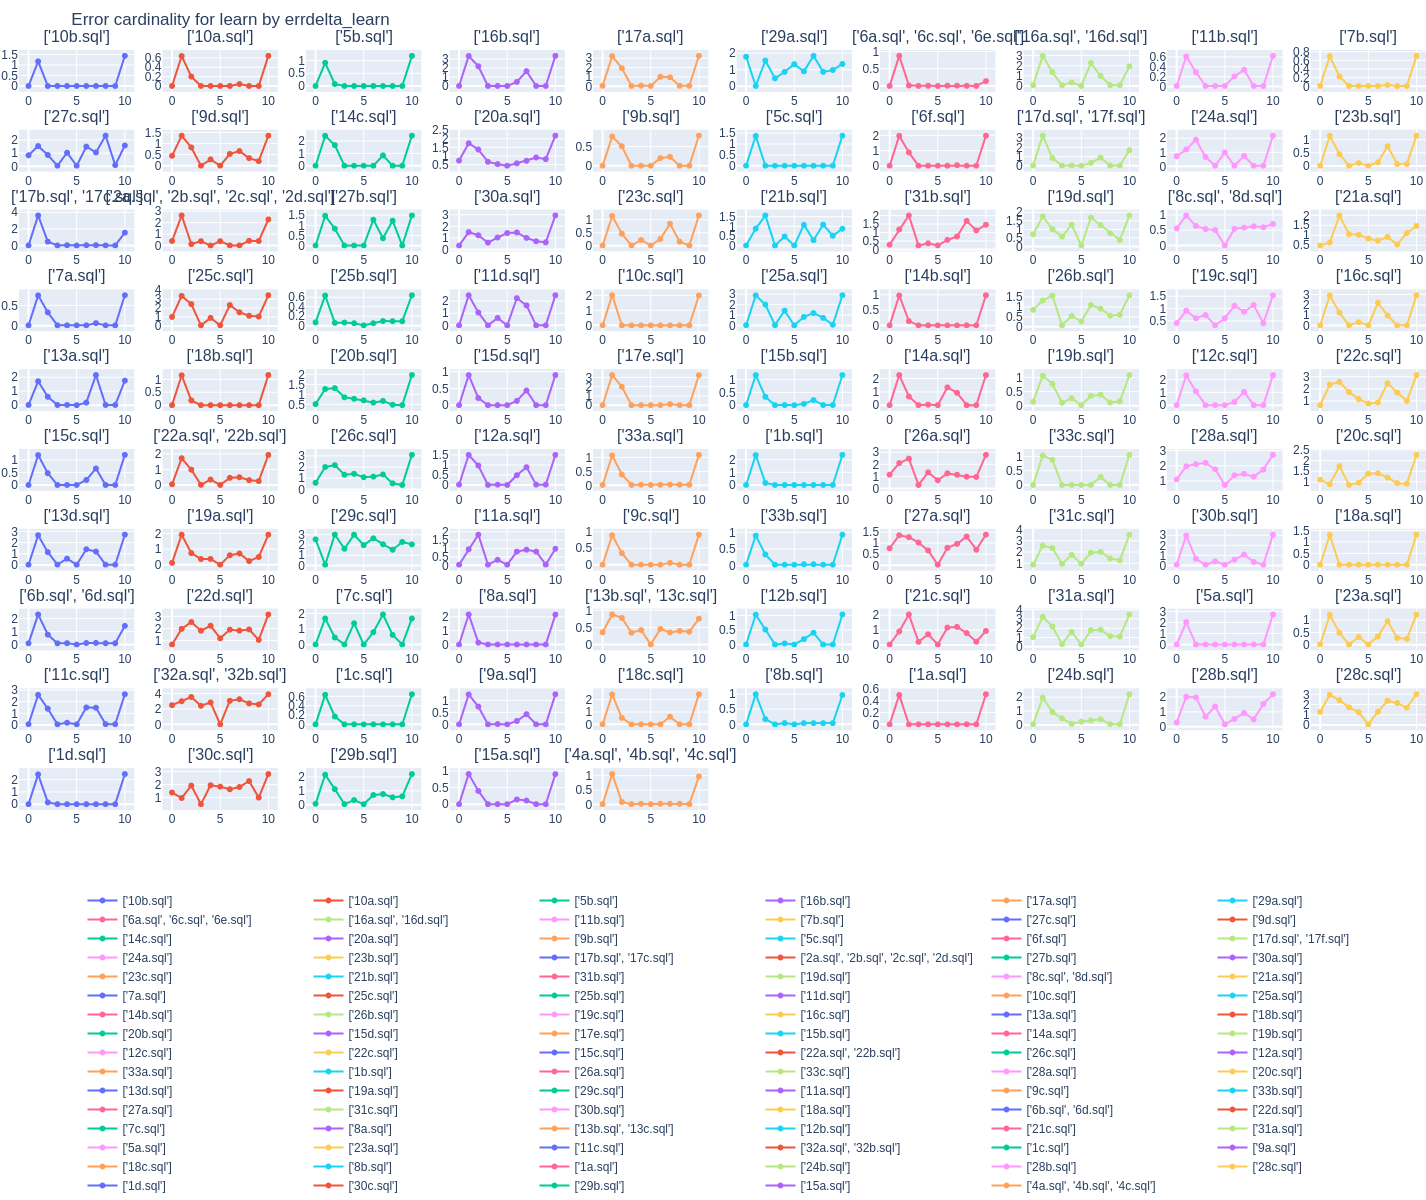

In [135]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_err[learn_df_query_err['query_name']==i]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['errdelta_learn']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                   title_text="Error cardinality for learn by errdelta_learn",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

### query_stats

In [136]:
name_query=list(learn_df_query_stat['query_name'])

In [137]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [138]:
oy=df_temp['cardinality_error_with_aqo_split'].to_list()

In [139]:
ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0])))

In [140]:
ox

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

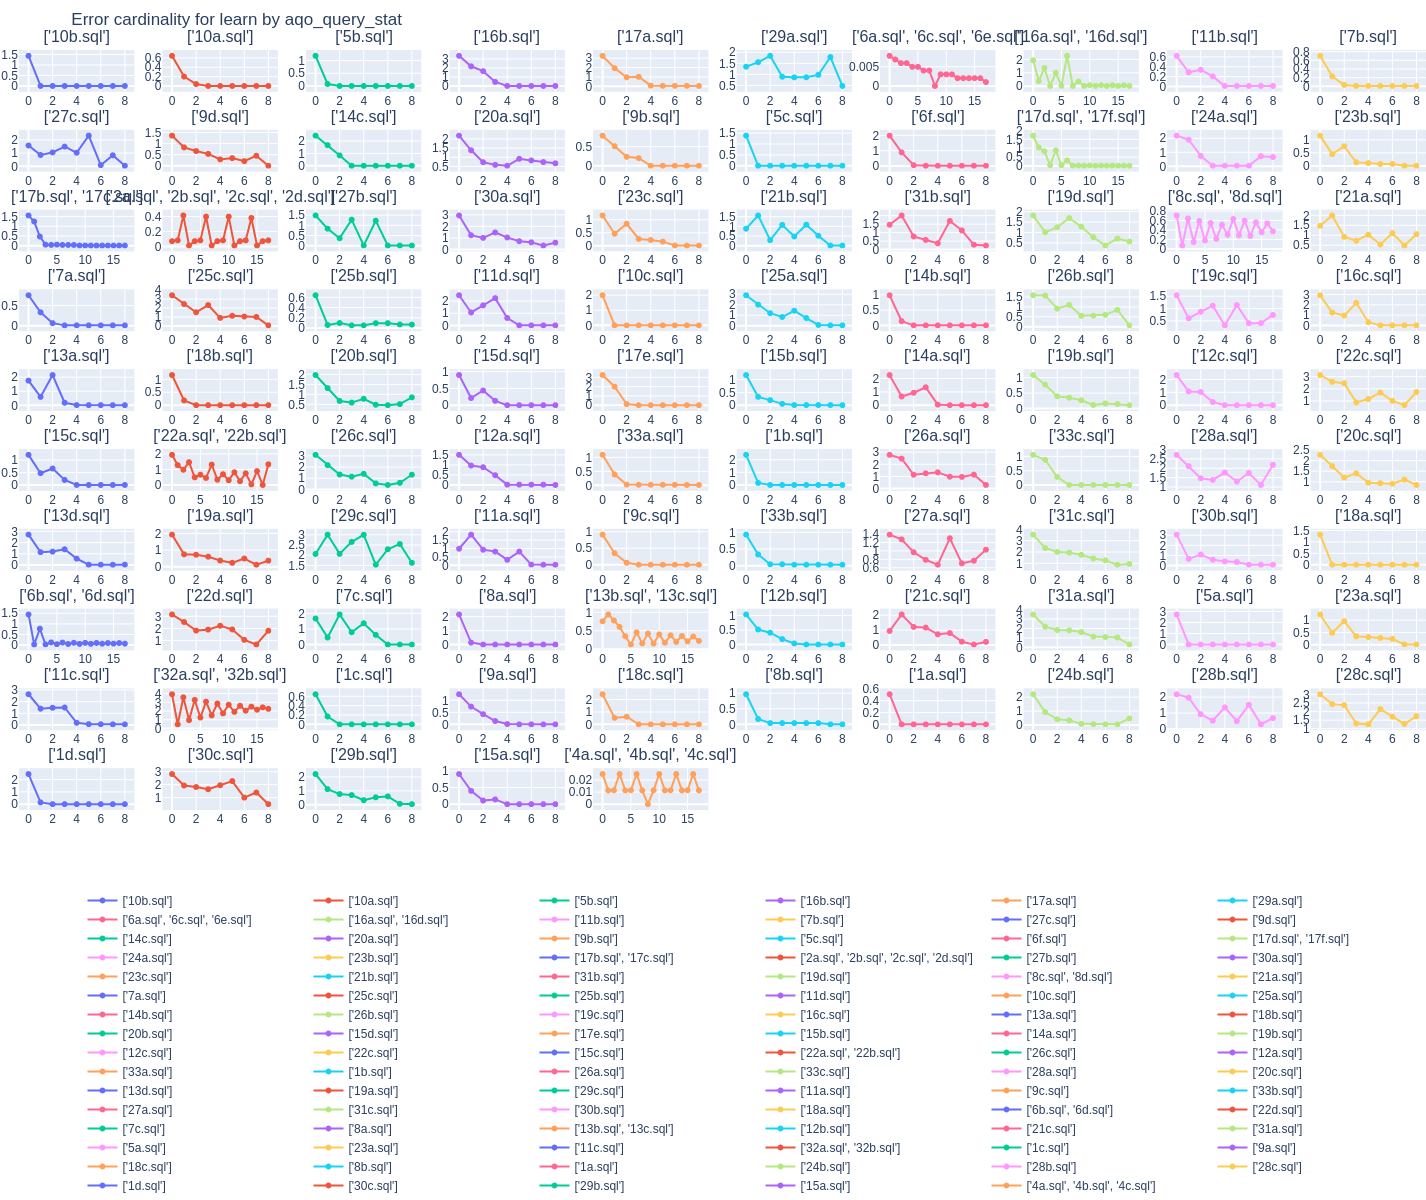

In [141]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['cardinality_error_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  title_text="Error cardinality for learn by aqo_query_stat",
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

## execution for every query

### learn_df_ex_pl_time_orig

In [142]:
name_query = list(learn_df_query_err['query_name'].unique())

In [143]:
ox=list(x for x in range(times))

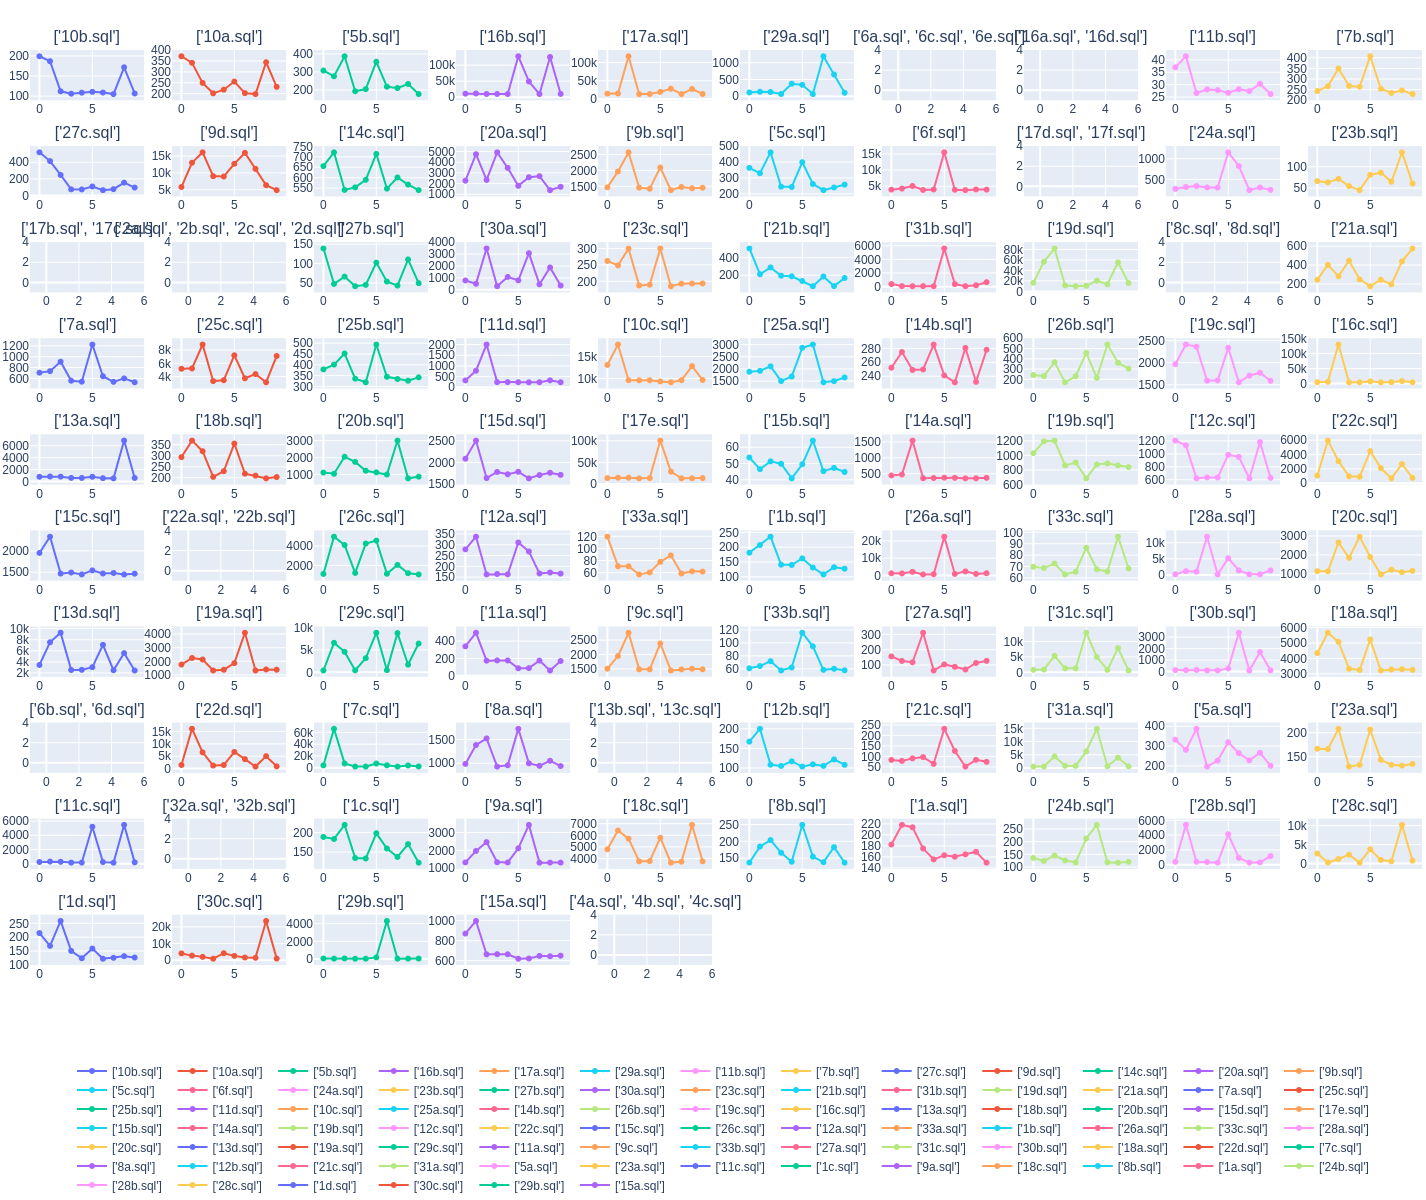

In [144]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

### learn_df_query_stat

In [145]:
name_query=list(learn_df_query_stat['query_name'])

In [146]:
df_temp=learn_df_query_stat[learn_df_query_stat['query_name']=="['15a.sql']"]

In [147]:
ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0])))

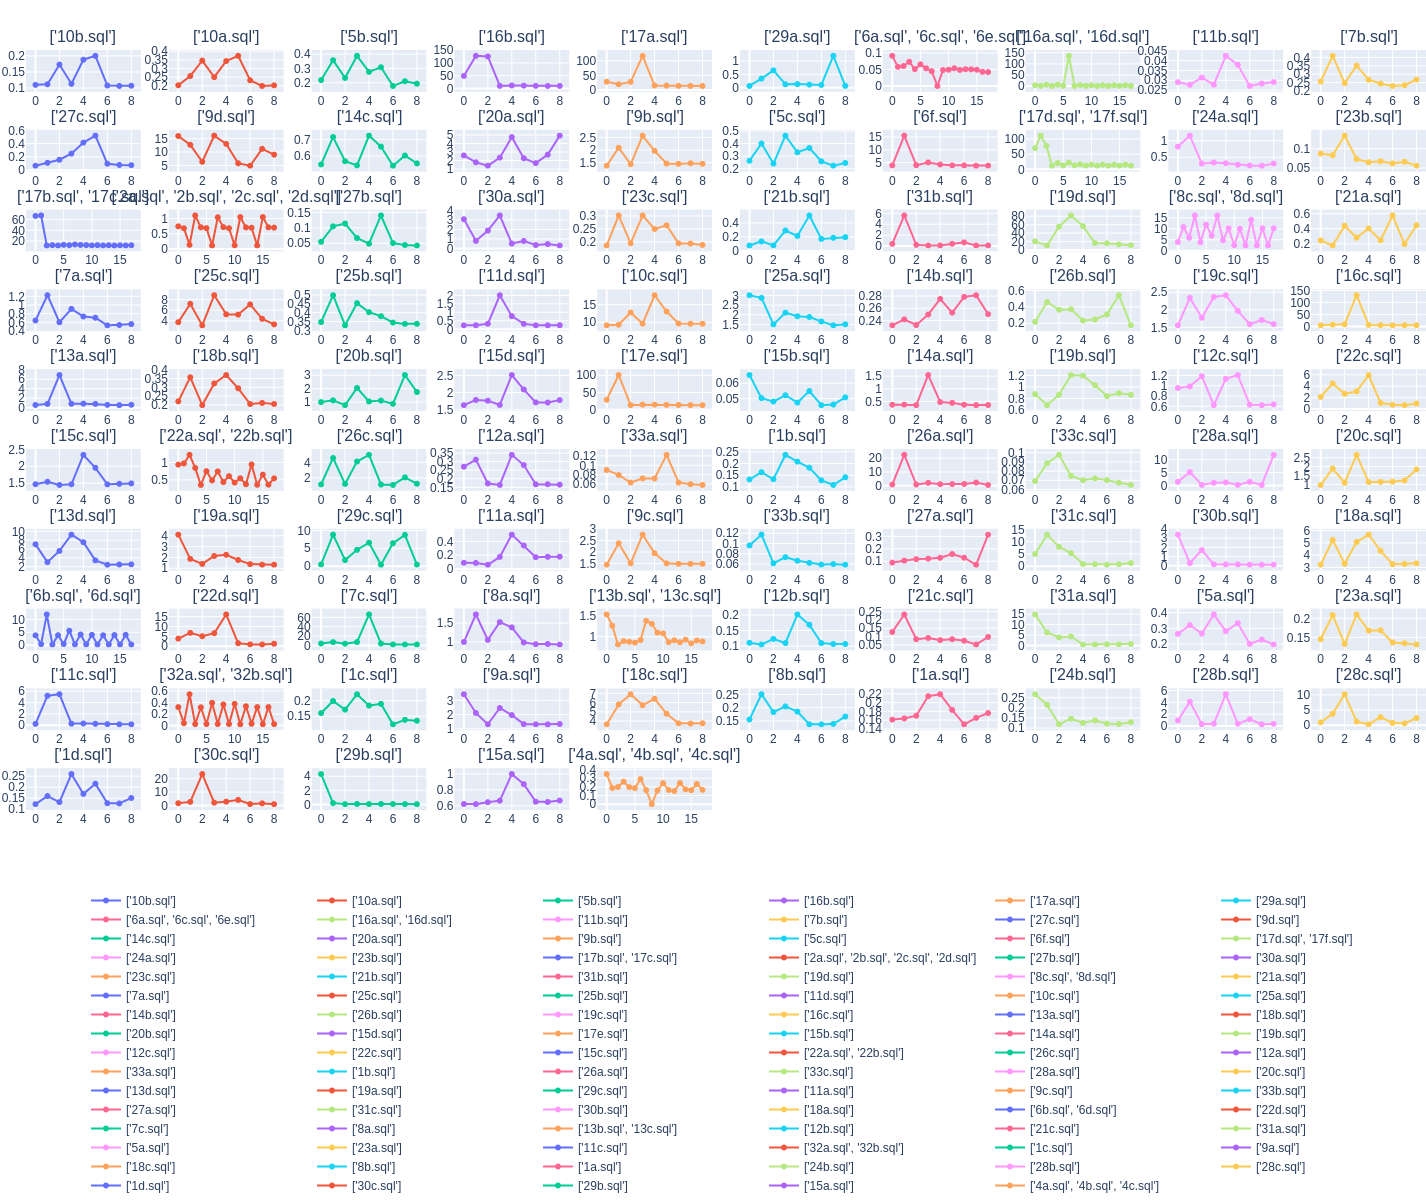

In [148]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['execution_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['execution_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

## plan for every query

### learn_df_ex_pl_time_orig

In [149]:
name_query = list(learn_df_query_err['query_name'].unique())

In [150]:
ox=list(x for x in range(times))

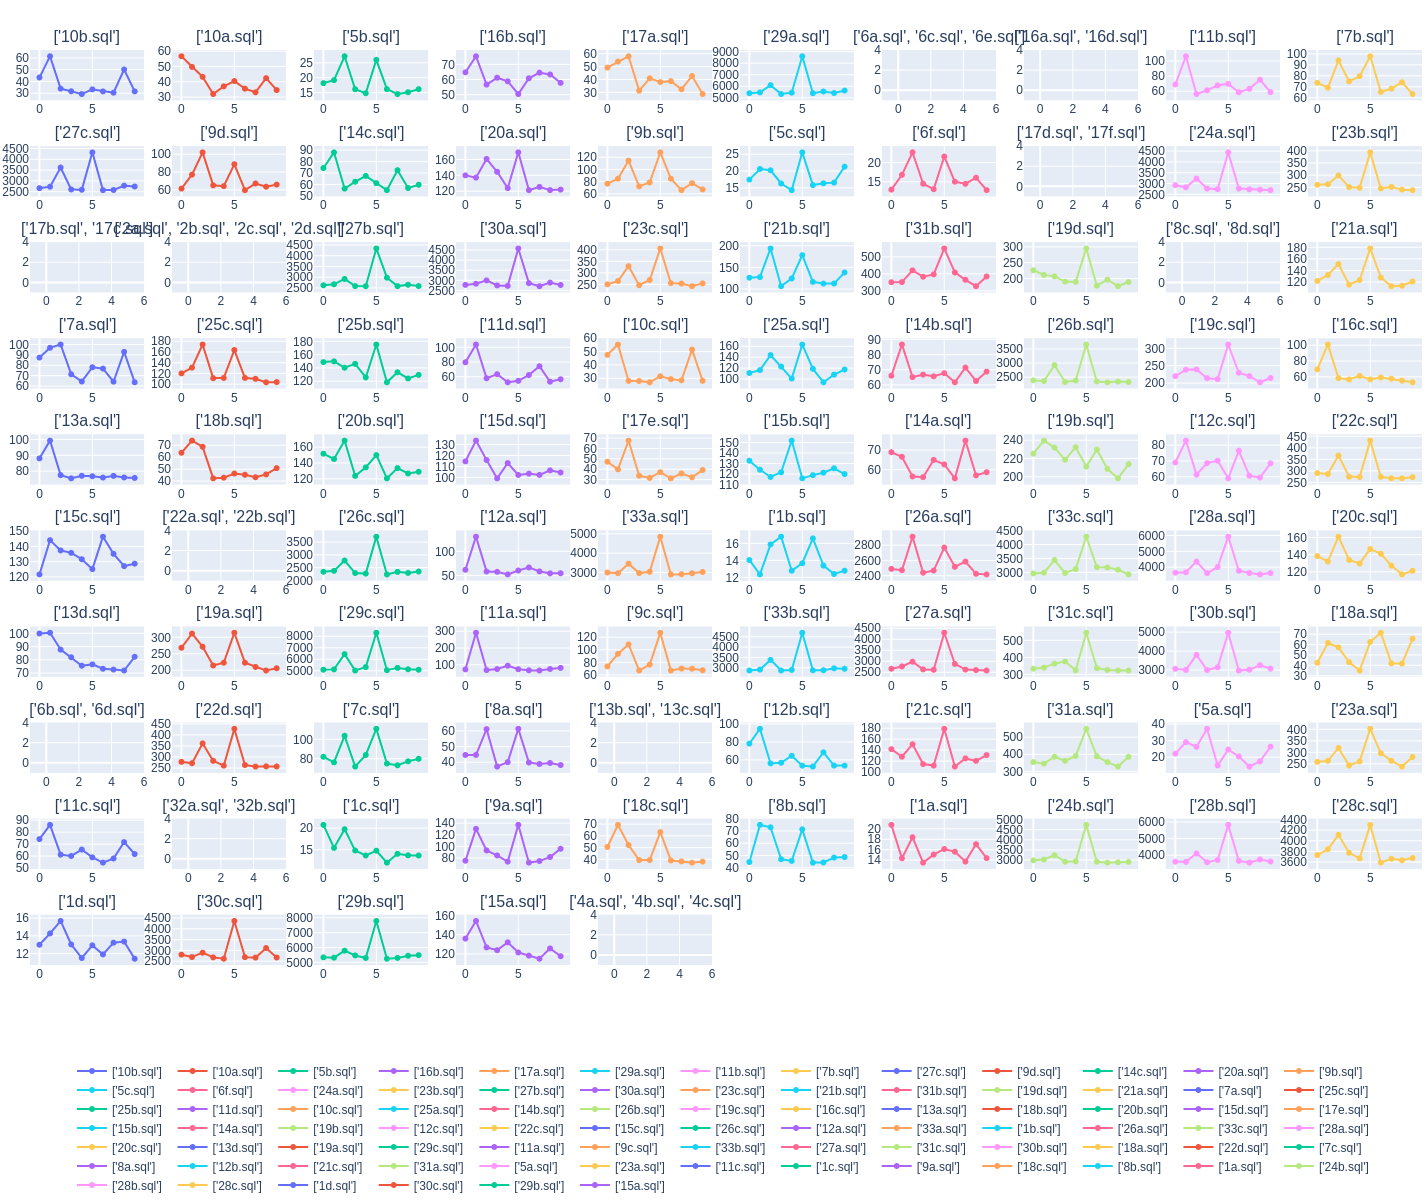

In [151]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_ex_pl_time_orig[learn_df_ex_pl_time_orig['query_name']==i[2:-2]]
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['plan_time']),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

### aqo_query_stat

In [152]:
name_query=list(learn_df_query_stat['query_name'])

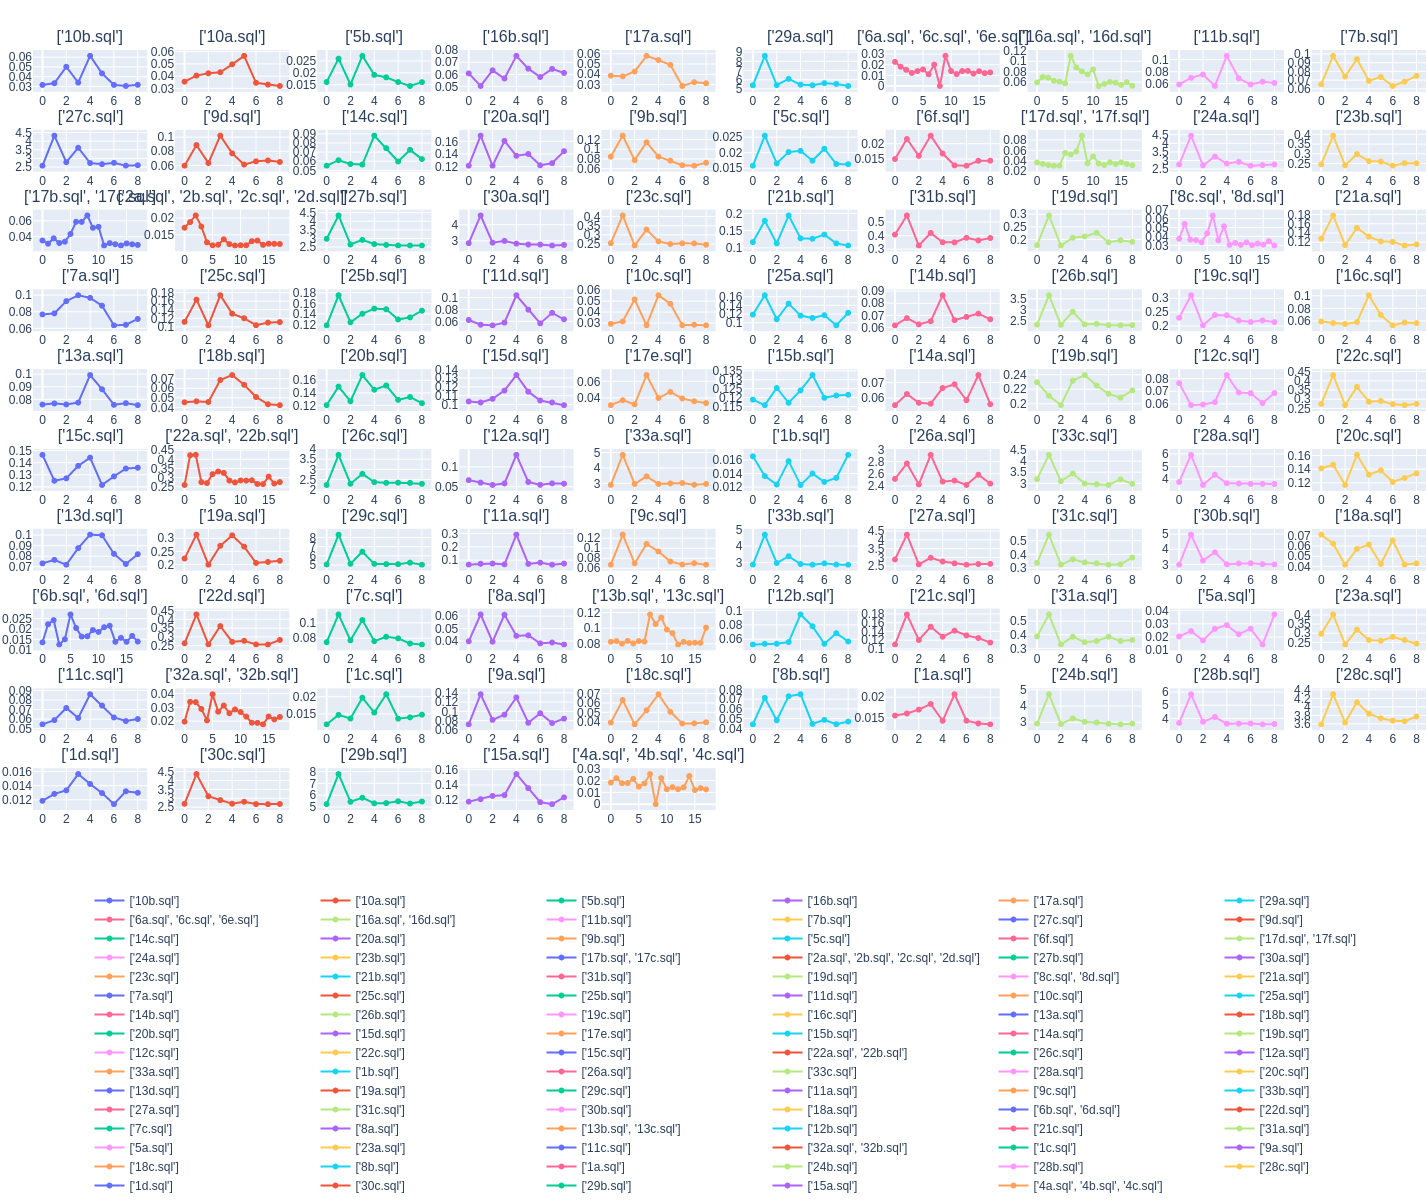

In [153]:
fig = make_subplots(rows=10, cols=10, subplot_titles=name_query)
for it, i in enumerate(name_query):
    df_temp=learn_df_query_stat[learn_df_query_stat['query_name']==i]
    ox=list(x for x in range(len(df_temp['planning_time_with_aqo_split'].to_list()[0][:-1])))
    fig.add_trace(
        go.Scatter(name=i,x = ox, y = df_temp['planning_time_with_aqo_split'].to_list()[0][:-1]),
        row=(it//10)+1, col=(it%10)+1
    )
    #fig.update_yaxes(zeroline=True, zerolinewidth=3, zerolinecolor='red')
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control))
    #fig.add_trace(go.Scatter(x = ox, y = val_control/val_control*2))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  margin=dict(l=0, r=0, t=50, b=0))
fig.update_layout(width=3000, height = 1200)
fig.show()

# build graphs: disabled and control

## query with plan and execution time

### df_ex_pl_time

In [154]:
df_ex_pl_time_copy=df_ex_pl_time.copy()

In [155]:
df_ex_pl_time_copy

query_number query_name  execution_time_frozen  plan_time_frozen  \
0               1    10a.sql                181.809            29.262   
1               1    10b.sql                 99.415            24.997   
2               1    10c.sql               9525.825            26.982   
3               1    11a.sql                163.727            65.220   
4               1    11b.sql                 22.544            51.039   
..            ...        ...                    ...               ...   
108             1     8d.sql               2416.847            31.695   
109             1     9a.sql               1440.430            70.451   
110             1     9b.sql               1433.294            65.512   
111             1     9c.sql               1480.953            63.620   
112             1     9d.sql               8802.779            59.463   

               query_hash  execution_time_disabled  plan_time_disabled  
0    -6651533820180303979                 2601.338              32.024  
1      988535410010893112                  102.595              16.417  
2     2494719406442254794                12575.065              12.784  
3    -8754961486292191806                  102.353              40.652  
4     7102013096890644952                   22.929              35.819  
..                    ...                      ...                 ...  
108  -2444720784039749802                 3864.600              18.416  
109  -6747521538659772949                 3675.287              34.434  
110    316739818532851506                 1443.151              39.083  
111   -180252288200201541                 1421.440              29.149  
112   7221379846823333251                16366.751              29.342  

[113 rows x 7 columns]

In [156]:
df_ex_pl_time_copy['diff_exec_time']=df_ex_pl_time_copy['execution_time_disabled']-df_ex_pl_time_copy['execution_time_frozen']

In [157]:
df_ex_pl_time_copy['rate_exec_time']=df_ex_pl_time_copy['execution_time_disabled']/df_ex_pl_time_copy['execution_time_frozen']

In [158]:
df_ex_pl_time_copy['diff_plan_time']=df_ex_pl_time_copy['plan_time_disabled']-df_ex_pl_time_copy['plan_time_frozen']

In [159]:
df_ex_pl_time_copy['rate_plan_time']=df_ex_pl_time_copy['plan_time_disabled']/df_ex_pl_time_copy['plan_time_frozen']

In [160]:
exec_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_exec_time']>=2]
plan_rate_2x=df_ex_pl_time_copy[df_ex_pl_time_copy['rate_plan_time']>=2]

In [161]:
exec_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<2) & (df_ex_pl_time_copy['rate_exec_time']>=1)]
plan_rate_1x=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<2) & (df_ex_pl_time_copy['rate_plan_time']>=1)]

In [162]:
exec_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<1) & (df_ex_pl_time_copy['rate_exec_time']>=0)]
plan_rate_more_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<1) & (df_ex_pl_time_copy['rate_plan_time']>=0)]

In [163]:
exec_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']<0)]
plan_rate_less_0=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_plan_time']<0)]

In [164]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]
lst_plan=[len(plan_rate_2x), len(plan_rate_1x), len(plan_rate_more_0)]

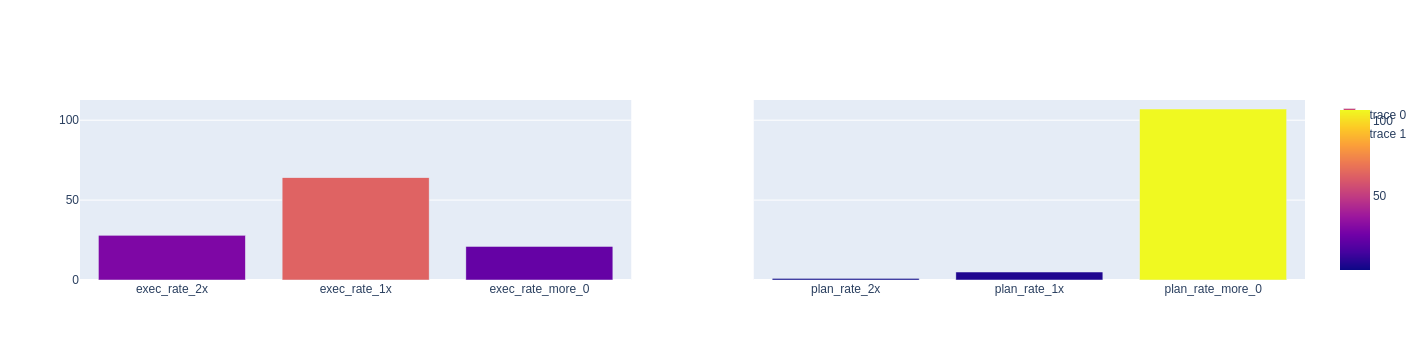

In [165]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),
              1, 1)
fig.add_trace(go.Bar(x=['plan_rate_2x', 'plan_rate_1x', 'plan_rate_more_0'], y=lst_plan,
                    marker=dict(color=lst_plan, coloraxis="coloraxis")),
              1, 2)
fig.show()

In [166]:
df_filter=df_ex_pl_time_copy[(df_ex_pl_time_copy['rate_exec_time']+df_ex_pl_time_copy['rate_plan_time'])>=2]

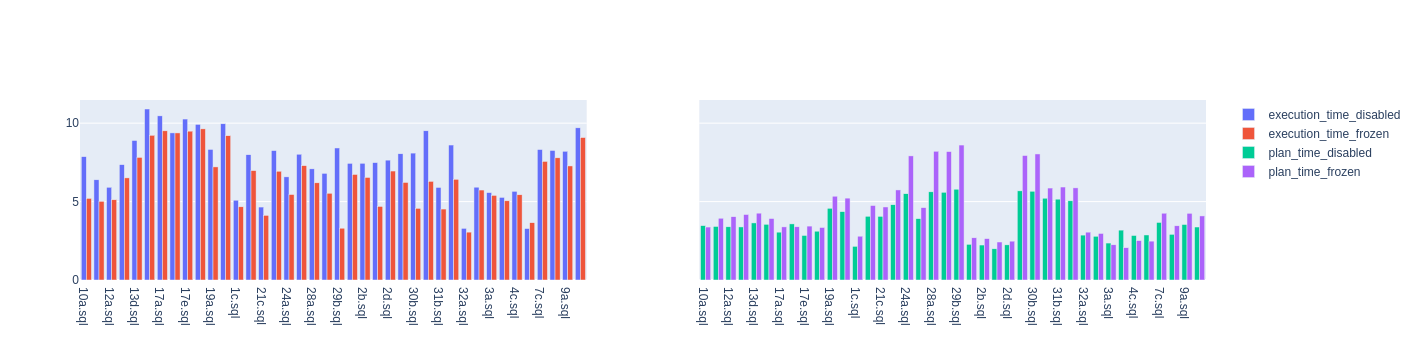

In [167]:
fig = make_subplots(rows=1, cols=2, shared_yaxes=True)
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=np.log(df_filter['execution_time_disabled'])),
              1, 1)
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['execution_time_frozen'])),
              1, 1)
fig.add_trace(go.Bar(name='plan_time_disabled',x=df_filter['query_name'], y=np.log(df_filter['plan_time_disabled'])),
              1, 2)
fig.add_trace(go.Bar(name='plan_time_frozen',x=df_filter['query_name'], y=np.log(df_filter['plan_time_frozen'])),
              1, 2)
fig.show()

### aqo_query_stat

In [168]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [169]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [170]:
execution_without=[]
for i in frozen_df_query_stat_copy.itertuples(index=False):
    if len(i.execution_time_without_aqo_split)==1:
        execution_without.append(i.execution_time_without_aqo_split[0])
    else:
        execution_without.append(i.execution_time_without_aqo_split[-1])

In [171]:
frozen_df_query_stat_copy['diff_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]-frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [172]:
frozen_df_query_stat_copy['rate_exec_time']=frozen_df_query_stat_copy['execution_time_without_aqo_split'][0]/frozen_df_query_stat_copy['lst_min_exec_with_aqo']

In [173]:
frozen_df_query_stat_copy['execution_time_without_aqo_split']

0                               [0.103413107]
1                               [2.603579312]
2                                [0.19399587]
3                              [54.372404818]
4                              [35.116374473]
                       ...                   
90                              [0.128673833]
91                               [1.74284339]
92                       [4.5286280009999995]
93                              [0.740570682]
94    [0.210879758, 0.144776803, 0.287439493]
Name: execution_time_without_aqo_split, Length: 95, dtype: object

In [174]:
exec_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_exec_time']>=2]

In [175]:
exec_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<2) & (frozen_df_query_stat_copy['rate_exec_time']>=1)]

In [176]:
exec_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<1) & (frozen_df_query_stat_copy['rate_exec_time']>=0)]

In [177]:
exec_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time']<0)]

In [178]:
lst_exec=[len(exec_rate_2x), len(exec_rate_1x), len(exec_rate_more_0)]

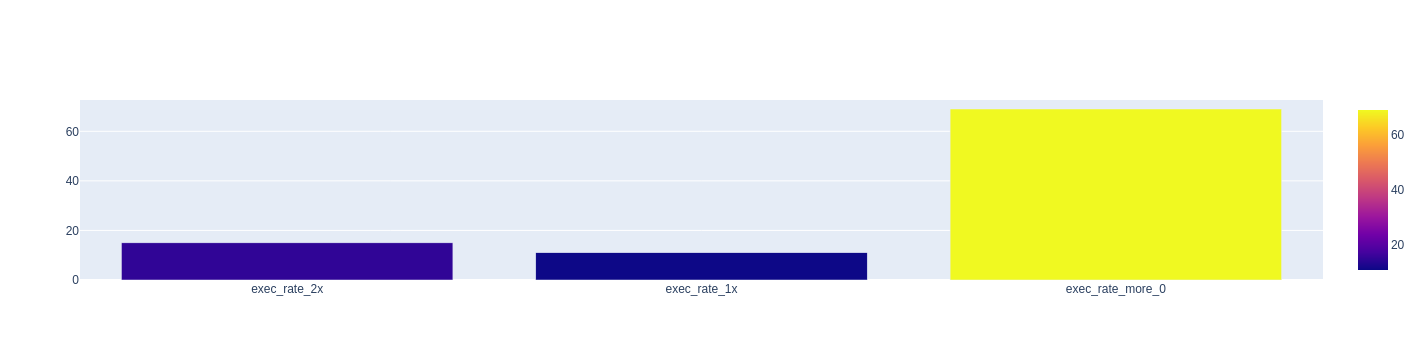

In [179]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['exec_rate_2x', 'exec_rate_1x', 'exec_rate_more_0'], y=lst_exec,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [180]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_exec_time'])>=2]

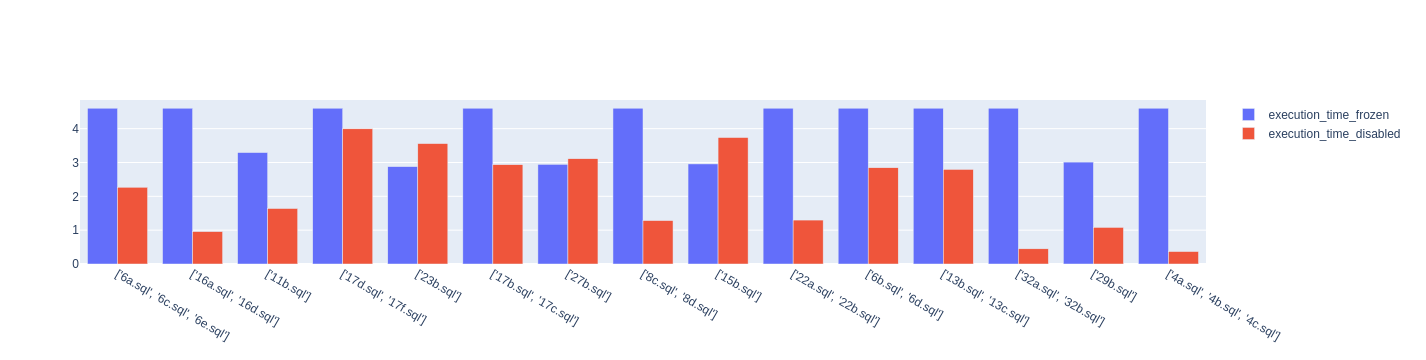

In [181]:
fig = go.Figure()
fig.add_trace(go.Bar(name='execution_time_frozen',x=df_filter['query_name'], y=abs(np.log(df_filter['lst_min_exec_with_aqo']+0.01))))
fig.add_trace(go.Bar(name='execution_time_disabled', x=df_filter['query_name'], y=abs(np.log(execution_without))))
fig.show()

## query with cardinality error

In [182]:
frozen_df_query_stat_copy=frozen_df_query_stat.copy()

In [183]:
frozen_df_query_stat_copy.columns

Index(['queryid', 'cardinality_error_without_aqo_split',
       'cardinality_error_with_aqo_split', 'planning_time_without_aqo_split',
       'planning_time_with_aqo_split', 'execution_time_without_aqo_split',
       'execution_time_with_aqo_split', 'executions_with_aqo',
       'executions_without_aqo', 'min_iter_card_with', 'lst_min_val_with_aqo',
       'min_iter_card_without', 'lst_min_val_without_aqo',
       'min_iter_exec_with', 'lst_min_exec_with_aqo',
       'cardinality_error_without_aqo_split_last_value',
       'cardinality_error_with_aqo_split_last_value', 'query_name'],
      dtype='object')

In [184]:
frozen_df_query_stat_copy['diff_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']-frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [185]:
frozen_df_query_stat_copy['rate_card_time']=frozen_df_query_stat_copy['cardinality_error_without_aqo_split_last_value']/frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']

In [186]:
card_rate_2x=frozen_df_query_stat_copy[frozen_df_query_stat_copy['rate_card_time']>=2]

In [187]:
card_rate_1x=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<2) & (frozen_df_query_stat_copy['rate_card_time']>=1)]

In [188]:
card_rate_more_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<1) & (frozen_df_query_stat_copy['rate_card_time']>=0)]

In [189]:
card_rate_less_0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time']<0)]

In [190]:
lst_card=[len(card_rate_2x), len(card_rate_1x), len(card_rate_more_0)]

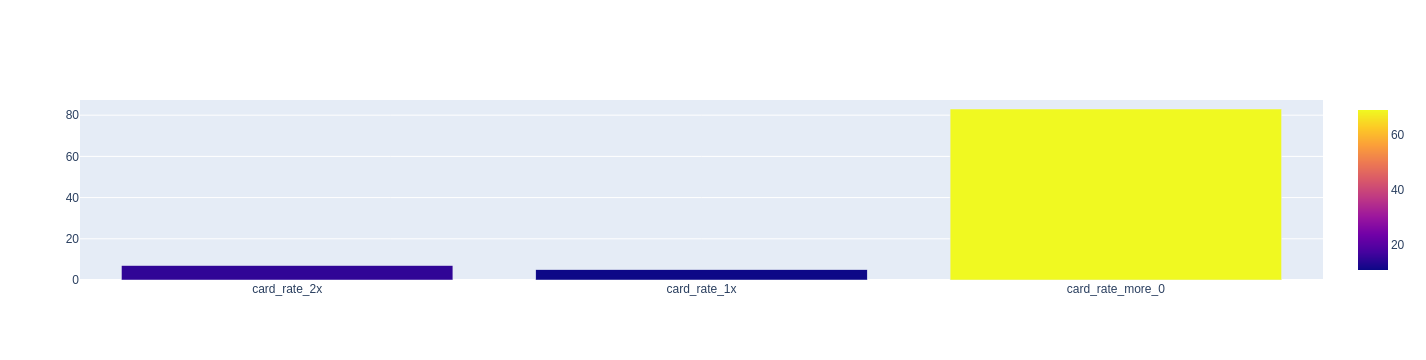

In [191]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_rate_2x', 'card_rate_1x', 'card_rate_more_0'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [192]:
card_less0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<=0.1) & (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0)]
card_eq0=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']==0)]
card_more0_1=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']>0.1) | (frozen_df_query_stat_copy['cardinality_error_with_aqo_split_last_value']<0)]

In [193]:
lst_card=[len(card_less0_1),len(card_eq0),len(card_more0_1)]

In [194]:
lst_card

[12, 0, 83]

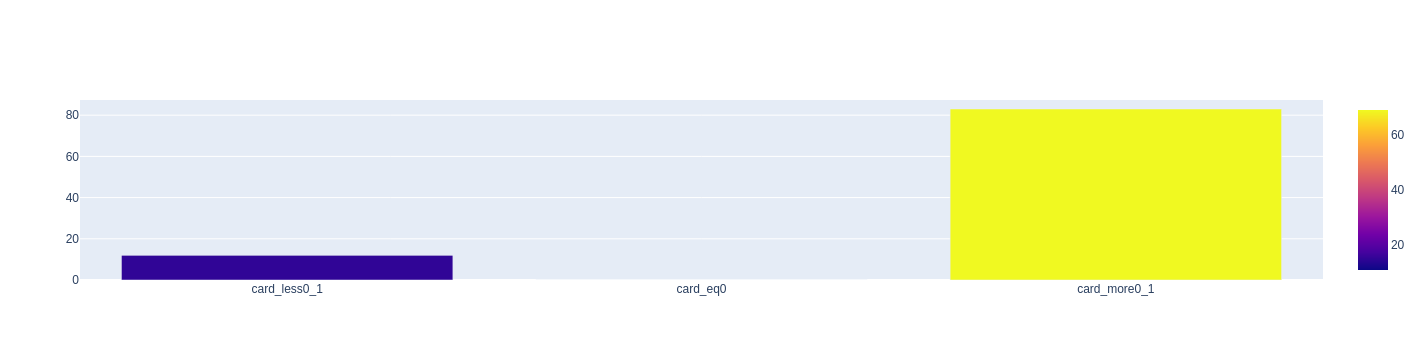

In [195]:
fig = go.Figure()
fig.add_trace(go.Bar(x=['card_less0_1', 'card_eq0', 'card_more0_1'], y=lst_card,
                    marker=dict(color=lst_exec, coloraxis="coloraxis")),)
fig.show()

In [196]:
df_filter=frozen_df_query_stat_copy[(frozen_df_query_stat_copy['rate_card_time'])>=2]

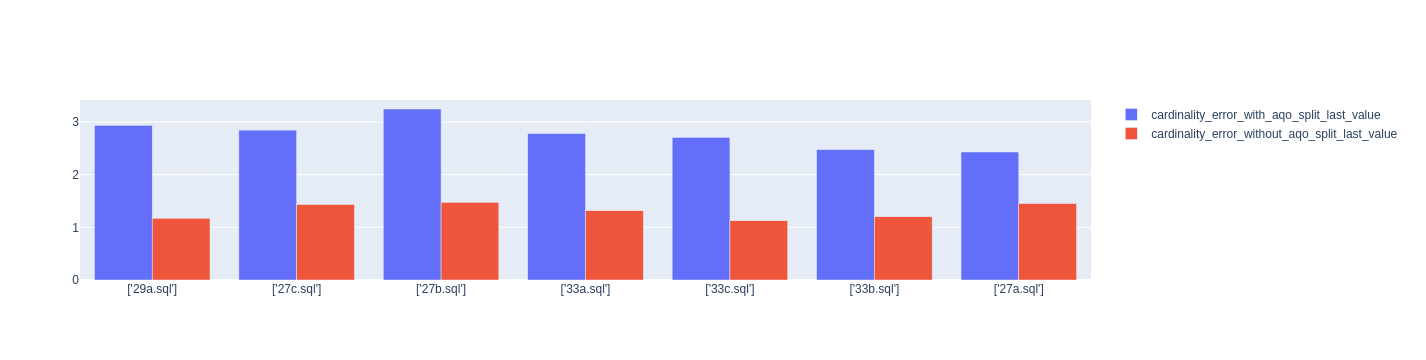

In [197]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error_with_aqo_split_last_value',x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_with_aqo_split_last_value']))))
fig.add_trace(go.Bar(name='cardinality_error_without_aqo_split_last_value', x=df_filter['query_name'], y=abs(np.log(df_filter['cardinality_error_without_aqo_split_last_value']))))
fig.show()

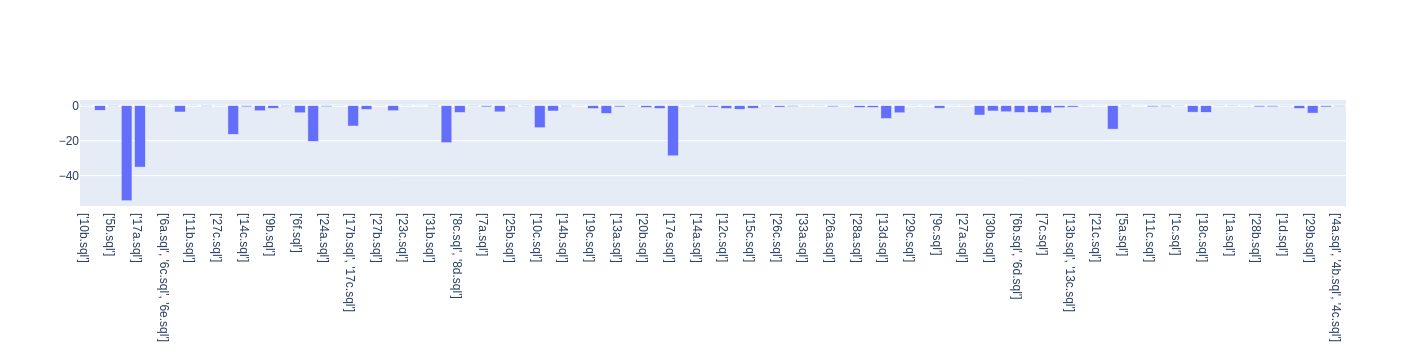

In [198]:
fig = go.Figure()
fig.add_trace(go.Bar(name='cardinality_error',x=frozen_df_query_stat_copy['query_name'], y=frozen_df_query_stat_copy['diff_card_time']))
fig.show()